## Installation

#### conda install -c ioos geopandas=0.2.0.dev0





## Using SD  to understand the SD Fever
### A new emerging infectious disease in Europe, which does not spread to neighboring countries

In this script, we will use georeferenced data at a national level to simulate a multiregional infectious disease model. We’ll then present the advantages to project spatial data produced by our simulation back on a map. 

In [1]:
%matplotlib inline
import pandas as pd
import pysd

/Users/houghton/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


### A simple SIR model
The model we’ll use to represent the dynamics of the disease is a simple SIR model, with individuals aggregated into stocks by their health condition S-Susceptible, I-Infectious, R-Recovered. We assume that the complete population is susceptible, therefore the initial value of susceptible stock is equal to the total population. In addition, we built on the hypothesis that from now all infected person are reported.

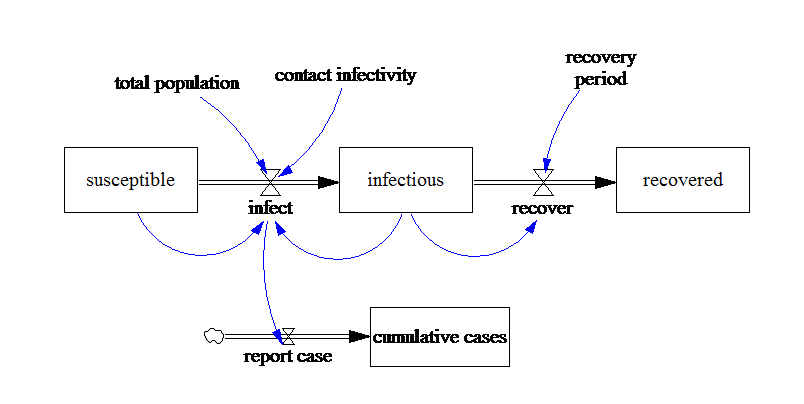

In [2]:
from IPython.display import Image
Image(filename='../../models/SD_Fever/SIR_model.png')

In Vensim our model was parameterized with 1000 suceptible, 5 infectious and 0 recovered individuals, a recovery period of 5 days and a contact infectivity of 70%. 

When we do not specificy anything else, the parameters and setting (e.g. timestep, simulation time) from the Vensim model are used. 

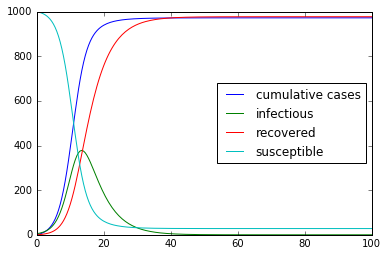

In [3]:
model = pysd.read_vensim('../../models/SD_Fever/SIR_Simple.mdl')
result = model.run()
result.plot();

# Recap

## Modify parameter values

As we have seen before, we can specify changes to the parameters of the model in the call to the run function. Here we set the contact infectivity to 30% before running the simulation again. If you like, try what happens when you change some of the other parameters.


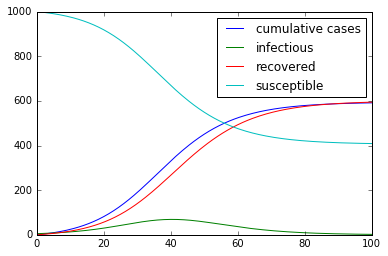

In [4]:
result = model.run(params={ 'total_population':1000,
                            'contact_infectivity':.3, 
                            'recovery_period': 5
                          })
result.plot();

## Change Model settings 

We can also change in a very simpe manner the simulation time and timestep of the model. An easy way to do it is to use numpy linspace which returns evenly spaced numbers over a specified interval.

np.linspace(Start, Stop, Number of timestamps)

In [5]:
import numpy as np
sim_time = 10
np.linspace(0, sim_time, num=sim_time*4+1)

array([  0.  ,   0.25,   0.5 ,   0.75,   1.  ,   1.25,   1.5 ,   1.75,
         2.  ,   2.25,   2.5 ,   2.75,   3.  ,   3.25,   3.5 ,   3.75,
         4.  ,   4.25,   4.5 ,   4.75,   5.  ,   5.25,   5.5 ,   5.75,
         6.  ,   6.25,   6.5 ,   6.75,   7.  ,   7.25,   7.5 ,   7.75,
         8.  ,   8.25,   8.5 ,   8.75,   9.  ,   9.25,   9.5 ,   9.75,  10.  ])

We can use the return_timestamps keyword argument in PySD. This argument expects a list of timestamps, and will return simulation results at those timestamps.

In [6]:
model.run(return_timestamps=np.linspace(0, sim_time, num=sim_time*2+1))

,cumulative cases,infectious,recovered,susceptible
0.0,0.000000,5.000000,0.000000,1000.000000
0.5,0.750000,5.250000,0.500000,999.250000
1.0,1.536909,5.511909,1.025000,998.463091
1.5,2.362425,5.786234,1.576191,997.637575
2.0,3.228310,6.073495,2.154814,996.771690
2.5,4.136393,6.374229,2.762164,995.863607
3.0,5.088572,6.688986,3.399587,994.911428
3.5,6.086815,7.018329,4.068485,993.913185
4.0,7.133156,7.362838,4.770318,992.866844
4.5,8.229704,7.723102,5.506602,991.770296


# Multi-regional SIR Model


## Geographical Information
Geospatial information as area on a map linked to several properties are  typically stored into shapefiles. 

For this script, we will use geopandas library to manage the shapefiles, and utilize its inherent plotting functionality. 

In [7]:
import geopandas as gp

shapefile = '../../data/SD_Fever/geo_df_EU.shp'
geo_data = gp.GeoDataFrame.from_file(shapefile)
geo_data.head(5)

ImportError: dlopen(/Users/houghton/anaconda/lib/python2.7/site-packages/fiona/ogrext.so, 2): Library not loaded: @rpath/libtiff.5.dylib
  Referenced from: /Users/houghton/anaconda/lib/libgdal.1.dylib
  Reason: Incompatible library version: libgdal.1.dylib requires version 8.0.0 or later, but libtiff.5.dylib provides version 7.0.0

Then we can project the geographic shape of the elements on a map.

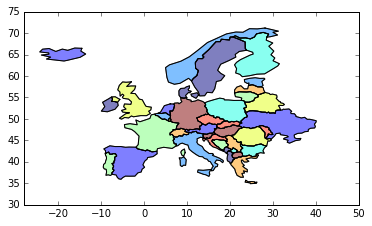

In [8]:
import matplotlib.pyplot as plt

geo_data.plot()
plt.xlim([-28, 50])
plt.ylim([30, 75])
plt.show()

And plot on of the georeferenced property (e.g. population)

In [9]:
geo_data.plot(column='population', scheme='fisher_jenks', alpha=0.9, k=9, linewidth=0.1,
             cmap=plt.cm.YlOrRd, legend=False)
plt.xlim([-28, 50])
plt.ylim([30, 75])
plt.show()

TypeError: plot_dataframe() got an unexpected keyword argument 'linewidth'

## Run the model for each country

We want to run the core SD model for each country, with country specific paramterization. 

Thus, we formulate a function that based on each row parameterizes the model with the value from geodata, performs the simulation and finally returns the number of infectious individuals over time.

In [10]:
def runner(row):
    sim_time = 200
    params= {'total_population':row['population'],
             'contact_infectivity' : row['inf_rate']}
    res = model.run(params=params,
                    return_timestamps=np.linspace(0, sim_time, num=sim_time*2+1))
    return res['infectious']

#### Apply function along rows of the Dataframe.

We want to apply the function row-wise (by country) therefore we set axis to 1 (row) instead of default 0 (column). The result is a new dataframe with the produced simulation for each country. 

In [12]:
res = geo_data.apply(runner, axis=1)
res.head()

,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,...,195.5,196.0,196.5,197.0,197.5,198.0,198.5,199.0,199.5,200.0
0,5.0,5.407815,5.848892,6.325945,6.841907,7.399952,8.003512,8.656299,9.362329,10.125943,...,1.235898e+01,1.174243e+01,1.115664e+01,1.060006e+01,1.007126e+01,9.568833e+00,9.091472e+00,8.637925e+00,8.207004e+00,7.797580e+00
1,5.0,5.127795,5.258857,5.393268,5.531115,5.672485,5.817468,5.966157,6.118646,6.275032,...,7.391140e+04,7.532471e+04,7.675456e+04,7.820069e+04,7.966278e+04,8.114054e+04,8.263360e+04,8.414161e+04,8.566416e+04,8.720083e+04
2,5.0,6.939664,9.631786,13.368267,18.554246,25.752025,35.742032,49.607441,68.851599,95.561003,...,8.710440e-08,7.927009e-08,7.216718e-08,6.579565e-08,6.015551e-08,5.514593e-08,5.050006e-08,4.620362e-08,4.225663e-08,3.865907e-08
3,5.0,4.958609,4.917560,4.876852,4.836480,4.796443,4.756736,4.717359,4.678307,4.639579,...,1.937845e-01,1.921802e-01,1.905892e-01,1.890113e-01,1.874465e-01,1.858947e-01,1.843557e-01,1.828294e-01,1.813158e-01,1.798147e-01
4,5.0,5.130475,5.264354,5.401727,5.542685,5.687321,5.835731,5.988013,6.144269,6.304603,...,7.030861e+04,7.130697e+04,7.230348e+04,7.329749e+04,7.428830e+04,7.527523e+04,7.625757e+04,7.723462e+04,7.820564e+04,7.916990e+04


## Transpose simulation results for plotting

The pandas line plot assumes that rows represent the timeseries and columns the different objects. Since our data is not yet in this form, we have to transpose the data.  In pandas all we have to do is add an .T at the end.

In [13]:
import pandas as pd
df = pd.DataFrame(res).T

In [14]:
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
0.5,5.407815,5.127795,6.939664,4.958609,5.130475,4.763649,5.630614,5.293347,5.993628,5.197358,...,7.459123,4.550577,5.240652,5.364989,5.125969,5.169376,5.245112,5.205252,4.595693,4.976995


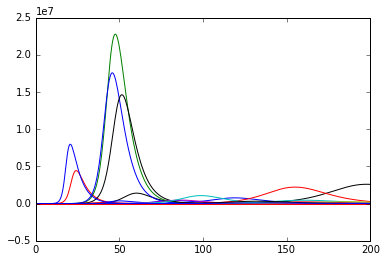

In [15]:
df.plot(legend=False);

## Comparative Analysis

Next lets try to compare how severe a country is hit by the SD fever.

Rather than looking at the number of infectious persons over time, a better indicator for comparative analysis are the cumulative cases as percentage of population in each country. 

We can reuse our code from before but instead of returning the number of infecious we return the cumulative cases.

In [16]:
def runner(row):
    sim_time = 200
    params= {'total_population':row['population'],
             'contact_infectivity' : row['inf_rate']}
    res = model.run(params=params,
                    return_timestamps=range(0,sim_time))
    return res['cumulative_cases']

#TIP: Ensure you are using lower case letters and the character _  not space

In [17]:
res = geo_data.apply(runner, axis=1)
res.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.0,1.931564,4.191064,6.834176,9.926028,13.542802,17.773617,22.722719,28.512051,35.284257,...,2.643414e+06,2.643416e+06,2.643418e+06,2.643420e+06,2.643421e+06,2.643423e+06,2.643424e+06,2.643425e+06,2.643426e+06,2.643427e+06
1,0.0,1.284525,2.635551,4.056522,5.551057,7.122967,8.776255,10.515136,12.344040,14.267628,...,3.207868e+05,3.353914e+05,3.505670e+05,3.663273e+05,3.826858e+05,3.996553e+05,4.172479e+05,4.354754e+05,4.543483e+05,4.738766e+05
2,0.0,6.044711,17.688969,40.119902,83.329609,166.565835,326.904336,635.757752,1230.660685,2376.436306,...,1.026049e+07,1.026049e+07,1.026049e+07,1.026049e+07,1.026049e+07,1.026049e+07,1.026049e+07,1.026049e+07,1.026049e+07,1.026049e+07
3,0.0,0.909294,1.803595,2.683151,3.548204,4.398995,5.235758,6.058724,6.868121,7.664172,...,5.280475e+01,5.284336e+01,5.288134e+01,5.291870e+01,5.295543e+01,5.299156e+01,5.302710e+01,5.306205e+01,5.309642e+01,5.313023e+01
4,0.0,1.290563,2.649358,4.079994,5.586268,7.172179,8.841937,10.599976,12.450961,14.399808,...,3.414903e+05,3.555252e+05,3.699699e+05,3.848232e+05,4.000827e+05,4.157447e+05,4.318042e+05,4.482554e+05,4.650906e+05,4.823014e+05


### Now, how do we get from the cumulative cases to the cumulative cases as % of the population? 

The answer is a simple matrix operation: divide row-wise the elements of our computed values by the column of the original geo data set where we had the population in each country.

Let's try to perform this type of operation on a minimal example. 

In [18]:
# Create arbitrary column
column = pd.Series([10, 0])
column

0    10
1     0
dtype: int64

In [19]:
# Create arbitrary pandas dataframe
df = pd.DataFrame(np.random.randint(1,5,size=(2, 3)), columns=list('ABC'))
df 

,A,B,C
0,1,3,3
1,1,2,4


In [20]:
column*df

,0,1,A,B,C
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN


Now we can translate this operation on our actual problem. 

In [21]:
res = pd.DataFrame(res.T/geo_data["population"])

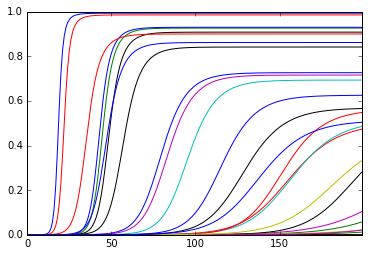

In [22]:
res.plot(legend=False);

## Analysis of results
For example, we could study the impact of contact infectivity on the cumulative cases at the end of the simulation

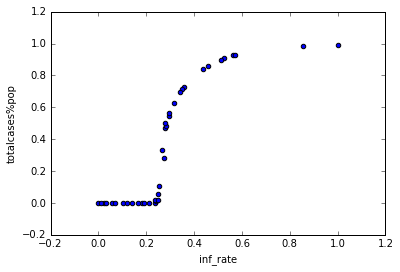

In [23]:
geo_data['totalcases%pop'] = res.loc[199] # Slice the final value at the end of the simulation
df_scatter = pd.DataFrame(geo_data) # Geopandas dataframe to pandas Dataframe (geopandas tries to perform spatial analysis)
df_scatter.plot.scatter(x='inf_rate', y='totalcases%pop'); # Plot infectivity versus cumulative cases at the end of the simulation

## How Spatial Analysis Leads to Insight

Finally, we present slighltly advanced Python scripts to get our simulation results projected on the map. 

We merge the complete simulation results with our original georeferenced information just as we did in the step before.

In [24]:
geo_data.head(2)

,country,geometry,inf_rate,population,totalcases%pop
0,Albania,"POLYGON ((20.59024743010491 41.85540416113361,...",0.356814,3639453.0,0.726325
1,Austria,"POLYGON ((16.97966678230404 48.12349701597631,...",0.250476,8210281.0,0.057717


In [25]:
res.head(2)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,5.307292e-07,1.564532e-07,5.804221e-07,1.262086e-07,2.797414e-07,5.094781e-08,3.247481e-07,1.628636e-07,4.117605e-08,2.622006e-07,...,4.582214e-07,1.133618e-08,4.005424e-08,1.709489e-07,5.763613e-08,1.868129e-07,2.840291e-07,7.280583e-07,1.592863e-08,2.077661e-08


In [26]:
geo_data_merged = geo_data.merge(res.T, left_index=True, right_index=True)
geo_data_merged.head()

,country,geometry,inf_rate,population,totalcases%pop,0,1,2,3,4,...,190,191,192,193,194,195,196,197,198,199
0,Albania,"POLYGON ((20.59024743010491 41.85540416113361,...",0.356814,3639453.0,0.726325,0.0,5.307292e-07,1.151564e-06,1.877803e-06,2.727341e-06,...,0.726322,0.726322,0.726323,0.726323,0.726324,0.726324,0.726324,0.726325,0.726325,0.726325
1,Austria,"POLYGON ((16.97966678230404 48.12349701597631,...",0.250476,8210281.0,0.057717,0.0,1.564532e-07,3.210062e-07,4.940783e-07,6.761105e-07,...,0.039071,0.040850,0.042699,0.044618,0.046611,0.048677,0.050820,0.053040,0.055339,0.057717
2,Belgium,"POLYGON ((3.314971144228537 51.34578095153609,...",0.855631,10414336.0,0.985227,0.0,5.804221e-07,1.698521e-06,3.852373e-06,8.001433e-06,...,0.985227,0.985227,0.985227,0.985227,0.985227,0.985227,0.985227,0.985227,0.985227,0.985227
3,Bulgaria,"POLYGON ((22.65714969248299 44.23492300066128,...",0.183375,7204687.0,0.000007,0.0,1.262086e-07,2.503363e-07,3.724174e-07,4.924856e-07,...,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007
4,Bosnia and Herzegovina,"POLYGON ((19.00548628101012 44.86023366960916,...",0.251521,4613414.0,0.104543,0.0,2.797414e-07,5.742728e-07,8.843763e-07,1.210875e-06,...,0.074021,0.077063,0.080194,0.083414,0.086722,0.090116,0.093598,0.097163,0.100813,0.104543


## Plotting simulation results on map with Ipywidgets

Ipywidgets are interactive HTML widgets for IPython notebooks. Users gain control of their data and can visualize changes in the data.

In [27]:
import matplotlib as mpl
from ipywidgets import interact, FloatSlider, IntSlider,RadioButtons, Dropdown
sim_time = 200
slider_time = IntSlider(description = 'Time Select',
                        min=0, max=sim_time-1, value=1)

C:\Users\Schwarz\AppData\Local\Enthought\Canopy32\User\lib\site-packages\geopandas\geodataframe.py:447: UserWarning: Unrecognized scheme "fisher-jenks". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)


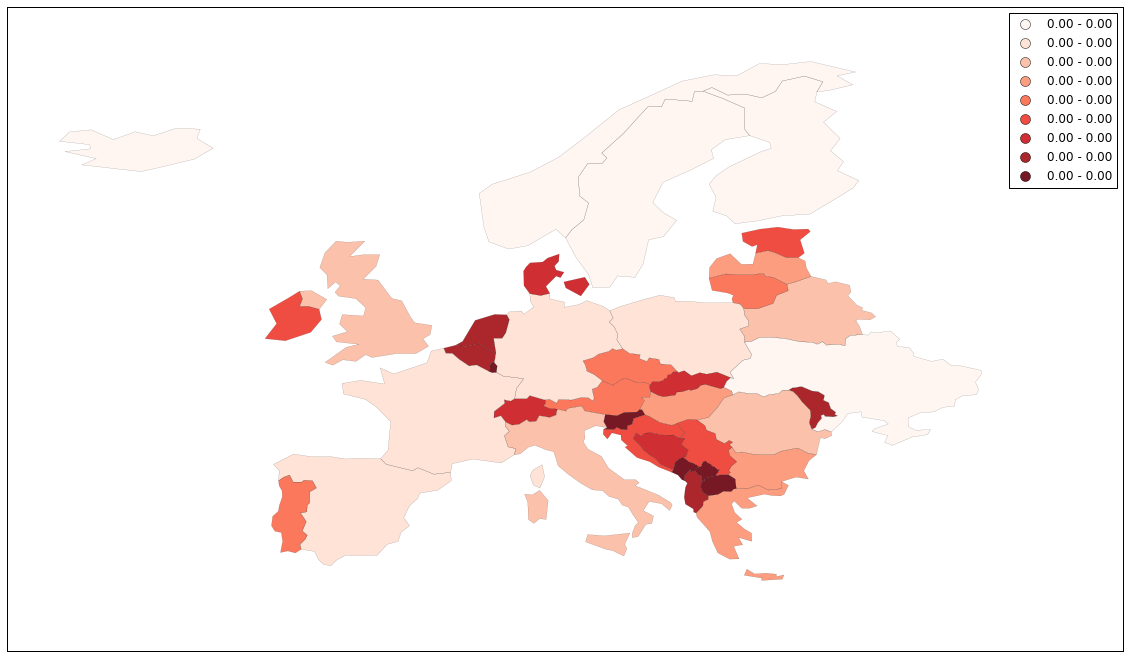

In [28]:
@interact( time = slider_time) # Scenario = select_scenario,
def update_map(time): # Scenario
    ax = geo_data_merged.plot(column=time, scheme='fisher-jenks', alpha=0.9, k=9, linewidth=0.1,
             cmap=plt.cm.Reds, legend=True,  figsize=(20, 30))
    plt.xlim(-28, 50)
    plt.ylim(30, 75)
    plt.xticks([])
    plt.yticks([])

...
